In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, desc

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
inspector = inspect(engine)
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [11]:
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

In [13]:
# Calculate the date 1 year ago from the last data point in the database
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_date

('2017-08-23')

In [14]:
# Perform a query to retrieve the data and precipitation scores
yr_data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date > '2016-08-22').all()

In [15]:
# Save the query results as a Pandas DataFrame and set the index to the date column
yr_df = pd.DataFrame(yr_data, columns=['date', 'precipitation'])
yr_df.set_index('date', inplace = True)

In [16]:
# Sort the dataframe by date
yr_df.sort_index()

,precipitation
date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15
2016-08-23,0.70
2016-08-23,0.02
2016-08-24,0.08
2016-08-24,2.15


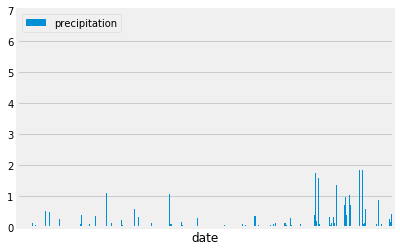

In [17]:
# Use Pandas Plotting with Matplotlib to plot the data
yr_df.plot.bar()
plt.xticks([])
plt.show()

In [18]:
# Use Pandas to calcualte the summary statistics for the precipitation data
yr_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [19]:
# Design a query to show how many stations are available in this dataset?
st_data = session.query(Measurement.date, Measurement.station).filter(Measurement.date > '2016-08-22').count()
st_data

2230

In [20]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
st_active = session.query(Measurement.station, func.count(Measurement.id)).\
    group_by(Measurement.station).\
    order_by(desc(func.count(Measurement.id))).all()
print(st_active)

[('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]


In [21]:
# Using the station id from the previous query, calculate
# the lowest temperature recorded,
low_t = session.query(Measurement.tobs).\
    filter(Measurement.station == 'USC00519281').\
    order_by(Measurement.tobs).first()
print(f'lowest temperature: {low_t}')

# highest temperature recorded,
high_t = session.query(Measurement.tobs).\
    filter(Measurement.station == 'USC00519281').\
    order_by(desc(Measurement.tobs)).first()
print(f'highest temperature: {high_t}')

# and average temperature of the most active station
avg_t = session.query(func.avg(Measurement.tobs).label('average')).\
    filter(Measurement.station == 'USC00519281').all()
print(f'average temperature: {avg_t}')

lowest temperature: (54.0,)
highest temperature: (85.0,)
average temperature: [(71.66378066378067,)]


In [22]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
last_date2 = session.query(Measurement.date).\
    filter(Measurement.station == 'USC00519281').\
    order_by(Measurement.date.desc()).first()
print(last_date2)

yr_data2 = session.query(Measurement.tobs).\
    filter(Measurement.station == 'USC00519281').\
    filter(Measurement.date > '2016-08-17').all()

yr_data2

('2017-08-18',)


[(80.0),
 (79.0),
 (81.0),
 (79.0),
 (78.0),
 (77.0),
 (77.0),
 (80.0),
 (80.0),
 (75.0),
 (73.0),
 (78.0),
 (77.0),
 (78.0),
 (80.0),
 (80.0),
 (78.0),
 (78.0),
 (78.0),
 (73.0),
 (74.0),
 (80.0),
 (79.0),
 (77.0),
 (80.0),
 (76.0),
 (79.0),
 (75.0),
 (79.0),
 (78.0),
 (79.0),
 (78.0),
 (78.0),
 (76.0),
 (74.0),
 (77.0),
 (78.0),
 (79.0),
 (79.0),
 (77.0),
 (80.0),
 (78.0),
 (78.0),
 (78.0),
 (77.0),
 (79.0),
 (79.0),
 (79.0),
 (79.0),
 (75.0),
 (76.0),
 (73.0),
 (72.0),
 (71.0),
 (77.0),
 (79.0),
 (78.0),
 (79.0),
 (77.0),
 (79.0),
 (77.0),
 (78.0),
 (78.0),
 (78.0),
 (78.0),
 (77.0),
 (74.0),
 (75.0),
 (76.0),
 (73.0),
 (76.0),
 (74.0),
 (77.0),
 (76.0),
 (76.0),
 (74.0),
 (75.0),
 (75.0),
 (75.0),
 (75.0),
 (71.0),
 (63.0),
 (70.0),
 (68.0),
 (67.0),
 (77.0),
 (74.0),
 (77.0),
 (76.0),
 (76.0),
 (75.0),
 (76.0),
 (75.0),
 (73.0),
 (75.0),
 (73.0),
 (75.0),
 (74.0),
 (75.0),
 (74.0),
 (75.0),
 (73.0),
 (75.0),
 (73.0),
 (73.0),
 (74.0),
 (70.0),
 (72.0),
 (70.0),
 (67.0),
 (67.0),
 

In [23]:
yr_df2 = pd.DataFrame(yr_data2, columns=['tobs'])
yr_df2

,tobs
0,80.0
1,79.0
2,81.0
3,79.0
4,78.0
5,77.0
6,77.0
7,80.0
8,80.0
9,75.0


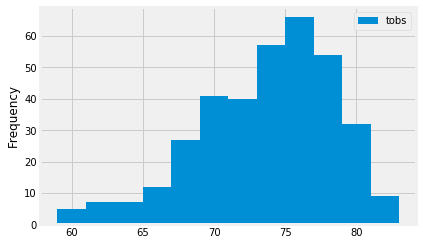

In [24]:
yr_df2.plot.hist(bins=12)
plt.show()

## testing

In [25]:
results = session.query(Measurement.date, Measurement.prcp).all()

In [26]:
date_list = []
prcp_list = []
for date, prcp in results:
    date_list.append(date)
    prcp_list.append(prcp)

date_prcp = dict(zip(date_list, prcp_list))
date_prcp

{'2010-01-01': 0.14,
 '2010-01-02': 0.0,
 '2010-01-03': 0.0,
 '2010-01-04': 0.0,
 '2010-01-06': 0.36,
 '2010-01-07': 0.3,
 '2010-01-08': 0.0,
 '2010-01-09': 0.0,
 '2010-01-10': 0.01,
 '2010-01-11': 0.14,
 '2010-01-12': 0.0,
 '2010-01-14': 0.0,
 '2010-01-15': 0.0,
 '2010-01-16': 0.0,
 '2010-01-17': 0.0,
 '2010-01-18': 0.0,
 '2010-01-19': 0.0,
 '2010-01-20': 0.0,
 '2010-01-21': 0.32,
 '2010-01-22': 0.0,
 '2010-01-23': 0.0,
 '2010-01-24': 0.01,
 '2010-01-25': 0.0,
 '2010-01-26': 0.03,
 '2010-01-27': 0.31,
 '2010-01-28': 0.07,
 '2010-01-30': 0.33,
 '2010-01-31': 1.1,
 '2010-02-01': 0.01,
 '2010-02-03': 0.67,
 '2010-02-04': 0.0,
 '2010-02-05': 0.09,
 '2010-02-06': 0.04,
 '2010-02-07': 0.0,
 '2010-02-08': 0.0,
 '2010-02-09': 0.0,
 '2010-02-11': 0.0,
 '2010-02-12': 0.65,
 '2010-02-13': 0.62,
 '2010-02-14': 0.02,
 '2010-02-15': 0.0,
 '2010-02-16': 0.0,
 '2010-02-17': 0.02,
 '2010-02-19': 0.42,
 '2010-02-20': 0.55,
 '2010-02-21': 0.0,
 '2010-02-22': None,
 '2010-02-23': 0.0,
 '2010-02-24': 0.0,

In [27]:
yr_tobs = session.query(Measurement.tobs).filter(Measurement.date > '2016-08-22').all()
print(type(yr_tobs))

<class 'list'>


In [28]:
results = session.query(Measurement.tobs).filter(Measurement.date > '2016-08-22').all()
res_list = list(np.ravel(results))
print(res_list)

[81.0, 79.0, 80.0, 79.0, 77.0, 78.0, 78.0, 79.0, 80.0, 81.0, 80.0, 79.0, 75.0, 79.0, 76.0, 76.0, 80.0, 79.0, 78.0, 76.0, 78.0, 78.0, 75.0, 79.0, 80.0, 79.0, 81.0, 77.0, 77.0, 78.0, 76.0, 82.0, 81.0, 78.0, 80.0, 80.0, 79.0, 80.0, 80.0, 80.0, 79.0, 79.0, 79.0, 80.0, 80.0, 79.0, 78.0, 76.0, 75.0, 80.0, 80.0, 79.0, 80.0, 79.0, 78.0, 78.0, 80.0, 81.0, 79.0, 77.0, 79.0, 78.0, 77.0, 77.0, 78.0, 77.0, 78.0, 77.0, 76.0, 77.0, 77.0, 77.0, 77.0, 77.0, 76.0, 75.0, 71.0, 71.0, 71.0, 71.0, 72.0, 71.0, 72.0, 77.0, 77.0, 77.0, 77.0, 77.0, 75.0, 76.0, 76.0, 75.0, 72.0, 74.0, 75.0, 73.0, 76.0, 75.0, 68.0, 75.0, 75.0, 72.0, 69.0, 71.0, 68.0, 67.0, 69.0, 73.0, 70.0, 70.0, 70.0, 66.0, 67.0, 70.0, 66.0, 62.0, 71.0, 73.0, 69.0, 77.0, 74.0, 71.0, 72.0, 74.0, 74.0, 74.0, 74.0, 71.0, 73.0, 69.0, 66.0, 62.0, 66.0, 63.0, 62.0, 63.0, 64.0, 66.0, 60.0, 64.0, 63.0, 78.0, 67.0, 67.0, 65.0, 66.0, 67.0, 66.0, 72.0, 73.0, 71.0, 72.0, 72.0, 72.0, 69.0, 72.0, 71.0, 65.0, 64.0, 67.0, 67.0, 68.0, 70.0, 61.0, 65.0, 72.0, 73.

In [29]:
low_temp = min(res_list)
low = print(f'lowest temperature: {low_temp}')

lowest temperature: 58.0


In [30]:
high_temp = max(res_list)
high = print(f'highest temperature: {high_temp}')

highest temperature: 87.0


In [31]:
avg_temp = sum(res_list)/len(res_list)
avg = print(f'average temperature: {avg_temp}')

average temperature: 74.59058295964125
